In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
!unzip '/content/drive/MyDrive/ACPS/Common_diseases.zip'

Archive:  /content/drive/MyDrive/ACPS/Common_diseases.zip
   creating: Common_diseases/
   creating: Common_diseases/Tar_Spot/
  inflating: Common_diseases/Tar_Spot/20230628-tarspot-1-720x400.webp  
  inflating: Common_diseases/Tar_Spot/9883630384_504442d19b_b.jpg  
  inflating: Common_diseases/Tar_Spot/0327T1-1602-1800x1012.jpg  
  inflating: Common_diseases/Tar_Spot/220825_tarspot_md.png  
  inflating: Common_diseases/Tar_Spot/93352_small.jpg  
  inflating: Common_diseases/Tar_Spot/yellow-maple-leaves-with-black-white-spots-fungal-disease-tar-spot-maple-leaf_716625-942.avif  
  inflating: Common_diseases/Tar_Spot/tarspont_lg.500x0.jpg  
  inflating: Common_diseases/Tar_Spot/12.-tar-spot-on-norway-maple.jpg  
  inflating: Common_diseases/Tar_Spot/4cedb523df8ad.image.jpg  
  inflating: Common_diseases/Tar_Spot/unnamed.jpg  
  inflating: Common_diseases/Tar_Spot/Tar spot severity.png  
  inflating: Common_diseases/Tar_Spot/Tarspot.jpg  
  inflating: Common_diseases/Tar_Spot/Corn tar spo

In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 1000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 6

In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training, ds=None):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        if ds is None:
            ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            # image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [64, 64])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 64, 64, 3))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 64, 64, 3))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

In [ ]:
def conv_bn(x, filter_size=64,kernel_size=3):
    x = layers.Conv2D(filters=filter_size, kernel_size=kernel_size, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(64, 64, 3))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_5 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                            

In [ ]:
data_dir = "/content/Common_diseases"
img_height = 64
img_width = 64
batch_size = 1

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds = train_ds.unbatch()
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.uint8), y))

val_ds = val_ds.unbatch()
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.uint8), y))

Found 296 files belonging to 10 classes.
Using 237 files for training.
Found 296 files belonging to 10 classes.
Using 59 files for validation.


In [ ]:
labels_name = os.listdir(data_dir)
labels_name.sort()
labels_name[2]

'Dog_vomit_slime_mold'

In [ ]:
train_dataset = Dataset(training=True, ds=train_ds)
test_dataset = Dataset(training=False, ds=val_ds)

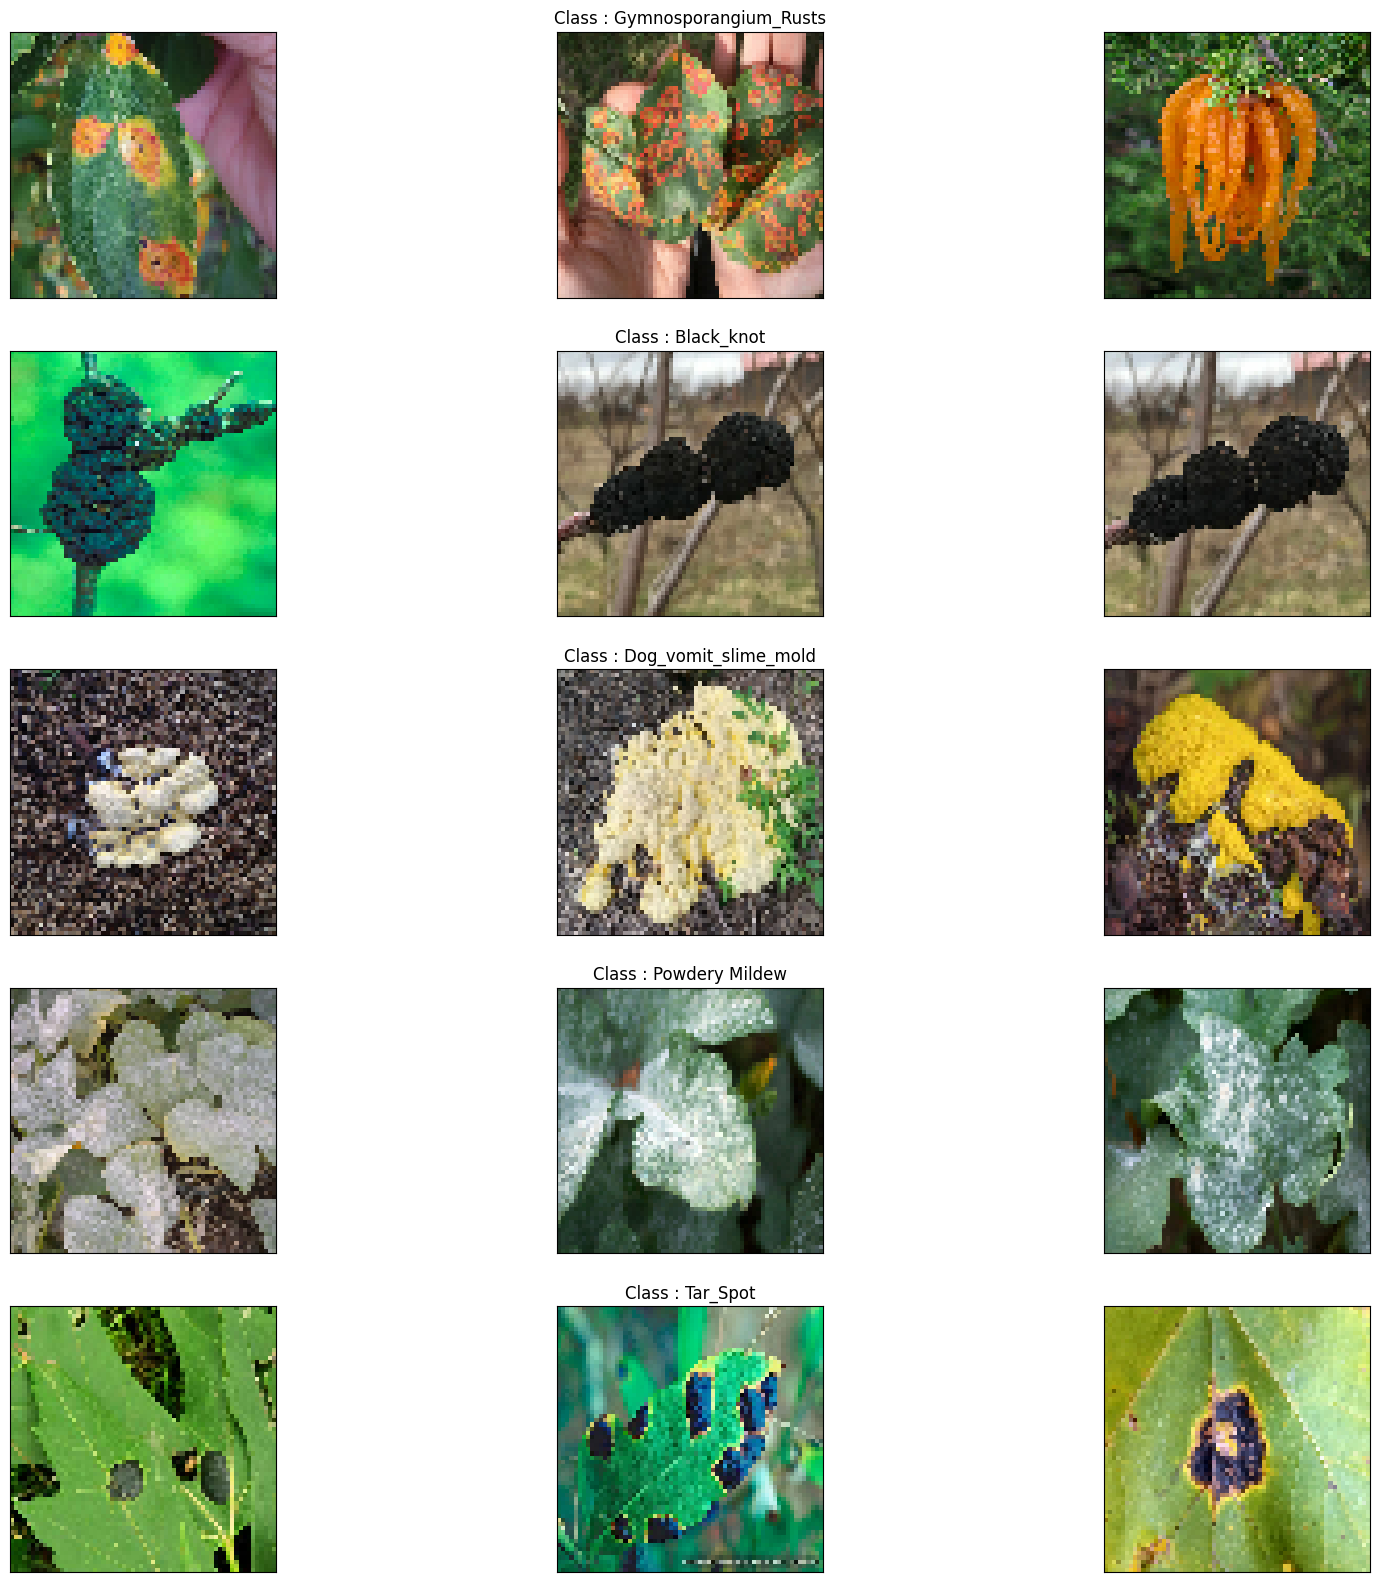

In [ ]:
_, axarr = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(3):
        temp_image = train_dataset.data[sample_keys[a]][b]
        # temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        # temp_image *= 255
        # temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 1:
            axarr[a, b].set_title("Class : " + labels_name[int(sample_keys[a])])
        axarr[a, b].imshow(temp_image)
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

In [ ]:
training = [0]
testing = [0]
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)

    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        if(accuracies[1] > testing[-1]):
          model.save_weights("./best_weights.h5", overwrite=True)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )


1/1 [==============================] - 0s 18ms/step
batch 0: train=0.333333 test=0.333333
1/1 [==============================] - 0s 19ms/step
batch 100: train=0.666667 test=0.833333
1/1 [==============================] - 0s 19ms/step
batch 200: train=0.333333 test=0.666667
1/1 [==============================] - 0s 18ms/step
batch 300: train=0.666667 test=0.666667
1/1 [==============================] - 0s 19ms/step
batch 400: train=1.000000 test=0.833333
1/1 [==============================] - 0s 18ms/step
batch 500: train=0.500000 test=0.666667
1/1 [==============================] - 0s 22ms/step
batch 600: train=0.833333 test=0.666667
1/1 [==============================] - 0s 20ms/step
batch 700: train=0.666667 test=0.833333
1/1 [==============================] - 0s 19ms/step
batch 800: train=0.833333 test=0.666667
1/1 [==============================] - 0s 23ms/step
batch 900: train=0.500000 test=0.833333
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 28ms/step


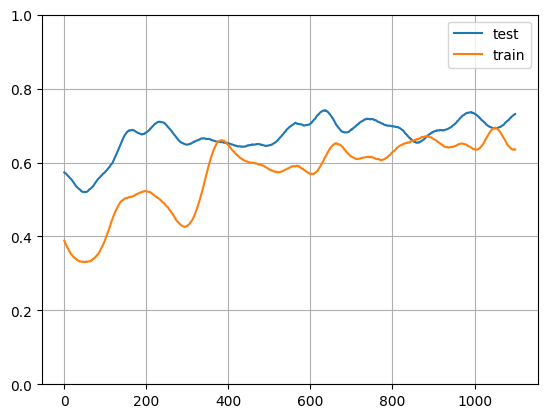

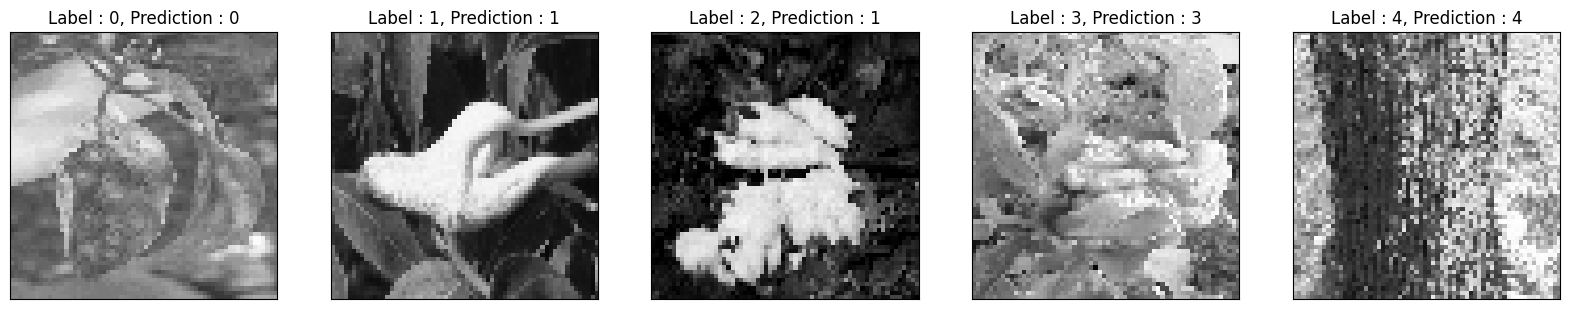

In [ ]:
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1],
    training,
    training[-1:-window_length:-1],
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.ylim(0, 1)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [ ]:
train_y[-1]

0.6354164670071119

In [ ]:
test_y[-1]

0.7312294735662144

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
